In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aimodelshare as ai


In [2]:
from google.colab import files
data_to_load = files.upload()

Saving X_test.csv to X_test (2).csv
Saving X_train.csv to X_train (1).csv
Saving y_train.csv to y_train (1).csv


In [14]:
import io
X_train = pd.read_csv(io.BytesIO(data_to_load['X_train.csv']))
X_test = pd.read_csv(io.BytesIO(data_to_load['X_test.csv']))
y_train = pd.read_csv(io.BytesIO(data_to_load['y_train.csv']))

In [15]:
X_train.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Peru,0.960,1.274,0.854,0.455,0.083,0.027,Peru,Americas,Latin America and the Caribbean,18.000000
1,Nicaragua,0.694,1.325,0.835,0.435,0.200,0.127,Nicaragua,Americas,Latin America and the Caribbean,125.611111
2,Greece,1.181,1.156,0.999,0.067,0.000,0.034,Greece,Europe,Southern Europe,112.000000
3,Qatar,1.684,1.313,0.871,0.555,0.220,0.167,Qatar,Asia,Western Asia,57.333333
4,Uzbekistan,0.745,1.529,0.756,0.631,0.322,0.240,Uzbekistan,Asia,Central Asia,125.611111


In [16]:
X_test.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Bulgaria,1.092,1.513,0.815,0.311,0.081,0.004,Bulgaria,Europe,Eastern Europe,7.000000
1,Serbia,1.004,1.383,0.854,0.282,0.137,0.039,Serbia,Europe,Southern Europe,2.000000
2,Mongolia,0.948,1.531,0.667,0.317,0.235,0.038,Mongolia,Asia,Eastern Asia,585.434783
3,Dominican Republic,1.015,1.401,0.779,0.497,0.113,0.101,Dominican Republic,Americas,Latin America and the Caribbean,1.000000
4,Burkina Faso,0.331,1.056,0.380,0.255,0.177,0.113,Burkina Faso,Africa,Sub-Saharan Africa,7.000000


In [17]:
y_train.head()

,Average,High,Low,Very High,Very Low
0,1,0,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,0,1,0
4,0,1,0,0,0


In [18]:
y_train_labels = y_train.idxmax(axis=1)

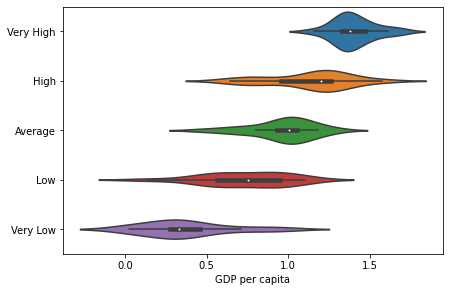

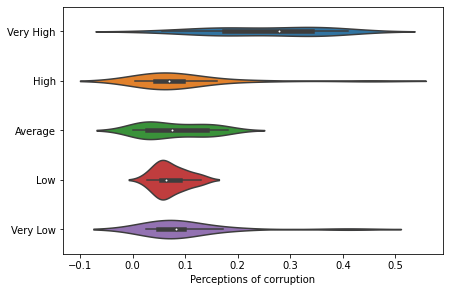

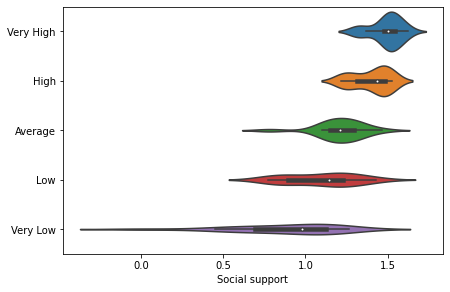

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.violinplot(x=X_train['GDP per capita'], y = y_train_labels, order=["Very High", "High", "Average", "Low", "Very Low"])

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.violinplot(x=X_train['Perceptions of corruption'], y = y_train_labels, order=["Very High", "High", "Average", "Low", "Very Low"])

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.violinplot(x=X_train['Social support'], y = y_train_labels, order=["Very High", "High", "Average", "Low", "Very Low"])

I visualized GDP per capita, Perceptions of Corruption, and Social Support against levels of happiness within a country with violin plots, which show the probability distributions of a country's happiness on different levels of GDP per capita, Perceptions of corruption, and Social support. It appears that GDP per capita is highly correlated with levels of happiness, and there seems to be a slight effect of social suport on happiness levels. Perceptions of corruption dont seem to affect happiness levels i.e. countries that have a low perception of corruption are not necessarily happier. However, the countries with the least corruption do tend to be most likely to be 'Very Happy'

We can see that 7 of the 10 features in our training data are continuous  numeric features, and the remaining ones are categorical. We will now check for any missing data before we scale our data and then train a model

In [7]:
X_train.isnull().sum()

Country or region               0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
name                            0
region                          0
sub-region                      0
Terrorist_attacks               0
dtype: int64

It appears we dont have any missing data points

We will now extract the feature importance 

In [31]:
X_train_numeric = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rfmodel = rf.fit(X_train_numeric, y_train)


print(rfmodel.feature_importances_)

[0.22444571 0.16683231 0.18898903 0.12411203 0.08311597 0.13004629
 0.08245865]


It seems that GDP per capita, Health Life Expectancy, and Social Support are the top three most important features  in predicting the happiness levels of a country.


We will now preprocess our data and fit some models!

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['region', 'sub-region']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocess=preprocessor.fit(X_train) 

In [22]:
def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [23]:
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


My first model will be a penalized Logistic Regression Model

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


param_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 100, 1000]} 

grid1 = GridSearchCV(LogisticRegression(penalty= 'l2', multi_class="multinomial", max_iter= 1000), param_grid=param_grid, cv=5)

grid1.fit(preprocessor(X_train), y_train_labels)
         
print(grid1.best_params_)
print(grid1.best_estimator_)
print(grid1.best_score_)



{'C': 0.5}
LogisticRegression(C=0.5, max_iter=1000, multi_class='multinomial')
0.6941176470588235


In [37]:
model1 =grid1.best_estimator_

In [38]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': np.arange(100, 600, 100), 
             'max_depth': np.arange(5, 50, 5)} 

grid2 = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)

grid2.fit(preprocessor(X_train), y_train_labels)
         
print(grid2.best_params_)
print(grid2.best_estimator_)
print(grid2.best_score_)

{'max_depth': 30, 'n_estimators': 100}
RandomForestClassifier(max_depth=30)
0.7490196078431371


In [40]:
model2 =grid2.best_estimator_

In [41]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(1, 20, 2)} 

grid3 = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5)

grid3.fit(preprocessor(X_train), y_train_labels)
         
print(grid3.best_params_)
print(grid3.best_estimator_)
print(grid3.best_score_)

{'n_neighbors': 7}
KNeighborsClassifier(n_neighbors=7)
0.6607843137254903


In [42]:
model3 = grid3.best_estimator_

In [ ]:
! pip install aimodelshare --upgrade

In [43]:
import aimodelshare as ai
from aimodelshare.aimsonnx import model_to_onnx
from aimodelshare.aws import set_credentials
from skl2onnx.common.data_types import FloatTensorType


feature_count=preprocessor(X_test).shape[1] 
initial_type = [('float_input', FloatTensorType([None, feature_count]))]

onnx_model1 = model_to_onnx(model1, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

onnx_model2 = model_to_onnx(model2, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

onnx_model3 = model_to_onnx(model3, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)




In [50]:
with open("model1.onnx", "wb") as f:
    f.write(onnx_model1.SerializeToString())

with open("model2.onnx", "wb") as f:
    f.write(onnx_model2.SerializeToString())

with open("model3.onnx", "wb") as f:
    f.write(onnx_model3.SerializeToString())

In [44]:
apiurl="https://e2w6gh3id1.execute-api.us-east-2.amazonaws.com/prod/m"

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [46]:
mycompetition= ai.Competition(apiurl)

In [51]:
prediction_labels_1 = model1.predict(preprocessor(X_test))

mycompetition.submit_model(model_filepath = "model1.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_1)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 742

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [52]:
prediction_labels_2 = model2.predict(preprocessor(X_test))

mycompetition.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_2)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 743

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [53]:
prediction_labels_3 = model3.predict(preprocessor(X_test))

mycompetition.submit_model(model_filepath = "model3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_3)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 744

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [ ]:
mycompetition.stylize_leaderboard(mycompetition.get_leaderboard())

I will now try to fit three more models



*   A SVC model
*   A gradient boosted model
*   A Voting Classifier which combines the predictions of all the other models



In [56]:
from sklearn.svm import SVC

param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1]}
grid4 = GridSearchCV(SVC(), param_grid)

grid4.fit(preprocessor(X_train), y_train_labels)
print(grid4.best_params_)
print(grid4.best_estimator_)
print(grid4.best_score_)

{'C': 1, 'gamma': 0.1}
SVC(C=1, gamma=0.1)
0.7052287581699346


In [57]:
model4 = grid4.best_estimator_

In [59]:
from sklearn.ensemble import GradientBoostingClassifier


param_grid ={"n_estimators":[5,50,250,500],
             "max_depth":[1,3,5,7,9],
             "learning_rate":[0.01,0.1,1,10,100]
             }

grid5 = GridSearchCV(GradientBoostingClassifier(), param_grid)


grid5.fit(preprocessor(X_train), y_train_labels)



GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [5, 50, 250, 500]})

In [60]:
print(grid5.best_params_)
print(grid5.best_estimator_)
print(grid5.best_score_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
GradientBoostingClassifier(max_depth=5, n_estimators=500)
0.6483660130718955


In [61]:
model5 = grid5.best_estimator_

In [83]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('lr', model1), ('rf', model2), ('knn', model3), ('svc', model4), ('gbc', model5)],
    voting='hard') 

model_v = voting_clf.fit(preprocessor(X_train), y_train_labels)

v_predictions = model_v.predict(preprocessor(X_test))

In [72]:


onnx_model4 = model_to_onnx(model4, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

onnx_model5 = model_to_onnx(model5, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

onnx_model_v = model_to_onnx(model_v, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

In [73]:
with open("model4.onnx", "wb") as f:
    f.write(onnx_model1.SerializeToString())

with open("model5.onnx", "wb") as f:
    f.write(onnx_model2.SerializeToString())

with open("modelv.onnx", "wb") as f:
    f.write(onnx_model_v.SerializeToString())

In [74]:
prediction_labels_4 = model4.predict(preprocessor(X_test))

mycompetition.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_4)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 808

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [75]:
prediction_labels_5 = model5.predict(preprocessor(X_test))

mycompetition.submit_model(model_filepath = "model5.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_5)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 809

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [84]:
mycompetition.submit_model(model_filepath = "modelv.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=v_predictions)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 811

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [ ]:
mycompetition.stylize_leaderboard(mycompetition.get_leaderboard())

In [86]:
leaderboard = mycompetition.get_leaderboard()



In [88]:
leaderboard.head()

,accuracy,f1_score,precision,recall,ml_framework,deep_learning,model_type,depth,num_params,flatten_layers,...,relu_act,tanh_act,softmax_act,loss,optimizer,memory_size,team,username,timestamp,version
0,0.558824,0.539394,0.682145,0.581429,sklearn,NaN,RandomForestClassifier,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6,sdp2158,2023-02-06 19:39:59.372410,510
1,0.588235,0.576515,0.655916,0.595000,sklearn,NaN,GradientBoostingClassifier,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yatharth,2023-01-31 22:48:33.976381,58
2,0.588235,0.576515,0.655916,0.595000,sklearn,NaN,GradientBoostingClassifier,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,four,ran_liao,2023-02-04 20:55:33.079937,299
3,0.588235,0.576515,0.655916,0.595000,sklearn,NaN,GradientBoostingClassifier,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,xilin0323,2023-02-07 16:44:16.780532,734
4,0.558824,0.518891,0.695000,0.566429,sklearn,NaN,GradientBoostingClassifier,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6,francesyang,2023-02-04 21:16:23.508811,305


In [96]:
my_results = leaderboard.loc[leaderboard['username'] == 'lah2228']
my_results = my_results.sort_values(by=['accuracy'], ascending=False)
my_results

,accuracy,f1_score,precision,recall,ml_framework,deep_learning,model_type,depth,num_params,flatten_layers,...,relu_act,tanh_act,softmax_act,loss,optimizer,memory_size,team,username,timestamp,version
421,0.441176,0.413968,0.592424,0.467143,sklearn,NaN,RandomForestClassifier,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,lah2228,2023-01-31 23:21:57.995979,77
456,0.441176,0.443423,0.507106,0.455714,sklearn,NaN,LogisticRegression,NaN,130.0,NaN,...,NaN,NaN,NaN,NaN,lbfgs,NaN,NaN,lah2228,2023-02-07 19:09:29.629318,808
470,0.441176,0.427312,0.523810,0.467143,sklearn,NaN,LogisticRegression,NaN,130.0,NaN,...,NaN,NaN,NaN,NaN,lbfgs,NaN,NaN,lah2228,2023-02-07 16:56:39.460038,742
545,0.441176,0.407698,0.526190,0.455714,sklearn,NaN,RandomForestClassifier,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,lah2228,2023-01-31 23:14:01.684006,76
452,0.411765,0.389089,0.619048,0.415714,sklearn,NaN,RandomForestClassifier,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lah2228,2023-02-07 19:09:47.711751,809
635,0.411765,0.412727,0.479487,0.427143,sklearn,NaN,VotingClassifier,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lah2228,2023-02-07 19:12:49.506858,811
731,0.382353,0.375758,0.429487,0.398571,sklearn,NaN,KNeighborsClassifier,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lah2228,2023-02-07 16:57:35.225263,744
746,0.382353,0.363232,0.439860,0.387143,sklearn,NaN,RandomForestClassifier,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lah2228,2023-02-07 16:57:19.307424,743


My best performing model in terms of accuracy of prediction was the random forest classifier and predicted the correct level of happiness 44.11% of the time. My best performing model in terms of f1_score was the penalized logistic regression model